In [1]:
import numpy as np
from scipy import integrate    
import matplotlib.pyplot as plt
import itertools
import arviz as az
import seaborn as sns
import pandas as pd
import pickle
sns.set_style("darkgrid")
pd.set_option('display.precision',1)
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
pd.set_option('display.float_format', '{:.2g}'.format)

In [2]:
full_fit = pickle.load(open("results/argn/horseshoe_ndx_0.07.p", "rb"))
fit = full_fit['fit']
S = full_fit['S']
R = full_fit['R']
D = full_fit['D']

### Posteror

In [4]:
nonzero_idx = []
nonzero_D = []
samples = fit.stan_variables()['rates']
for i in range(samples.shape[0]):
    inferred_rates = samples[i,:]
    inferred_rates[inferred_rates < 1e-3] = 0
    nonzero_idx.append(np.argwhere(inferred_rates != 0)[:,0])

In [5]:
obs = pickle.load(open("results/argn/obs_0.07.p", "rb"))
t = obs["t"]
Z_obs = obs["Z_obs"]
Z_obs_noisy = obs["Z_obs_noisy"]
species_names = ['g', 'p_2', 'g.p_2', 'r', 'p']

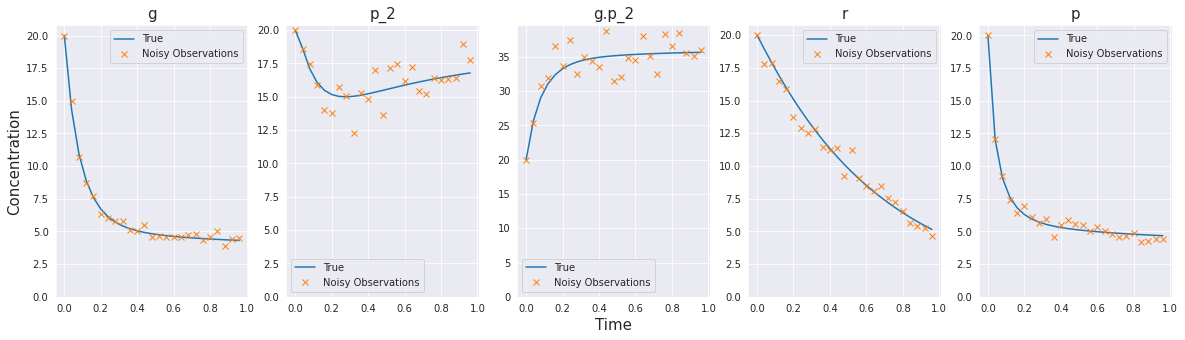

In [50]:
#fig = plt.figure()
#ax = []
#ax.append(fig.add_subplot(3, 4, (1,2)))
#ax.append(fig.add_subplot(3, 4, (3,4)))
#ax.append(fig.add_subplot(3, 4, (5,6)))
#ax.append(fig.add_subplot(3, 4, (7,8)))
#ax.append(fig.add_subplot(3, 4, (10, 11)))
fig, ax = plt.subplots(1, 5)

for i in range(5):
    ax[i].plot(t, Z_obs[:,i], color = 'C0', label = 'True')
    ax[i].plot(t, Z_obs_noisy[:,i], 'x', color = 'C1', label = 'Noisy Observations')
    ax[i].legend()
    ax[i].set_title(species_names[i], fontsize = 15)
    ax[i].set_ylim([0, None])
ax[0].set_ylabel("Concentration", fontsize = 15)
ax[2].set_xlabel("Time", fontsize = 15)
fig.set_size_inches(20, 5)
plt.savefig("figures/argn_obs.png", dpi = 400)

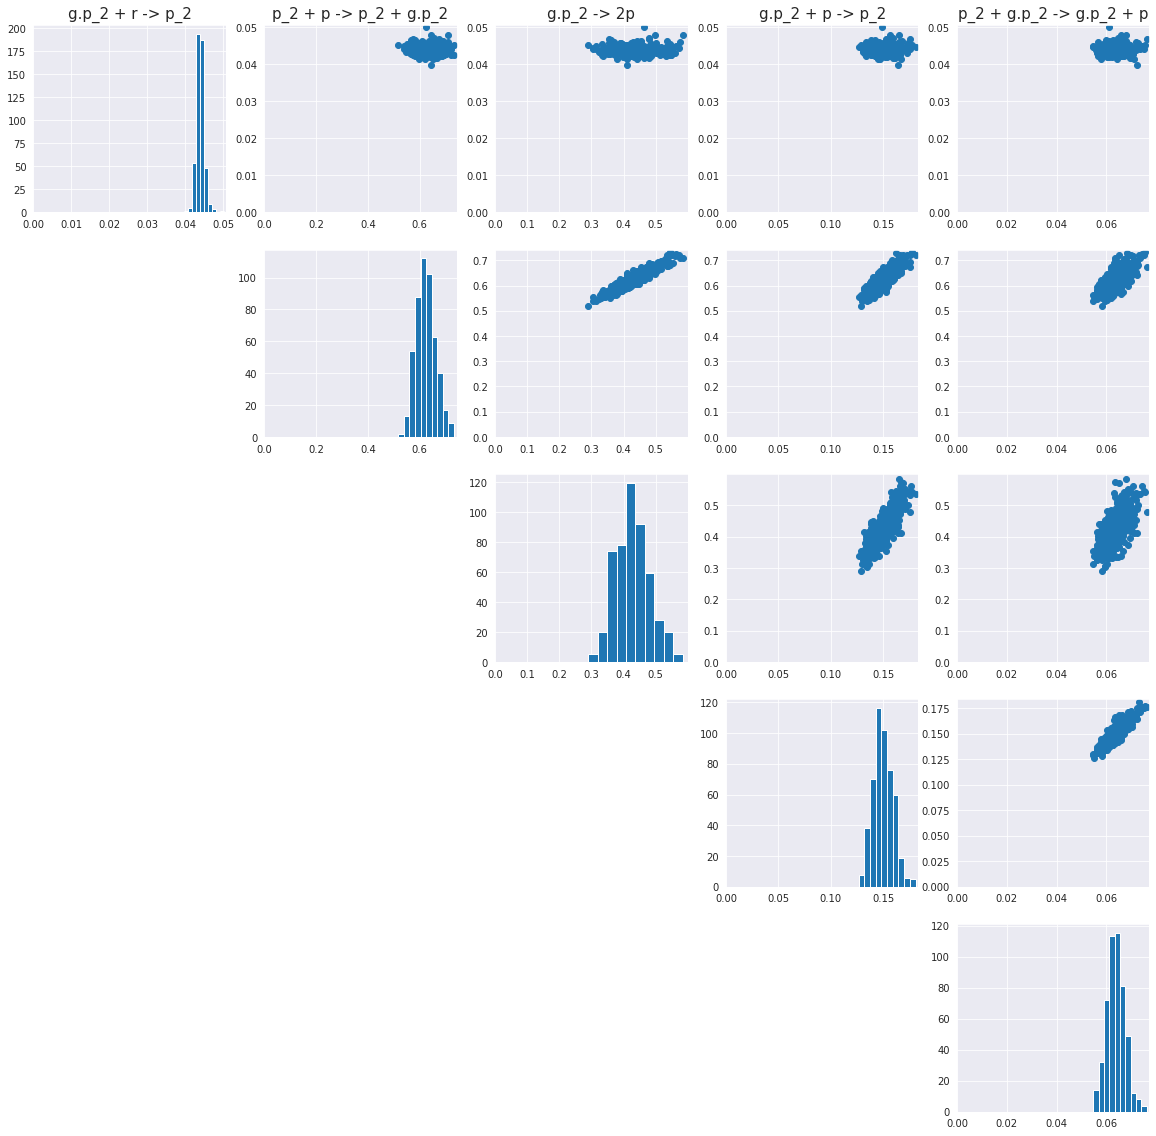

In [38]:
red_samples = samples[0:500,nonzero_idx[0][4:]]

fig, ax = plt.subplots(red_samples.shape[1], red_samples.shape[1])
for i in range(red_samples.shape[1]):
    ax[0][i].set_title(D[nonzero_idx[0][4:][i]], fontsize = 15)
    for j in range(i, red_samples.shape[1]):
        if i == j:
            ax[i][j].hist(red_samples[:,i])
            ax[i][j].set_xlim([0, None])
        else:
            ax[i][j].scatter(red_samples[:,j], red_samples[:,i])
            ax[i][j].set_xlim([0, None])
            ax[i][j].set_ylim([0, None])
            ax[j][i].axis('off')
fig.set_size_inches(20, 20)
plt.savefig("figures/argn_posterior_1.png", dpi = 400)

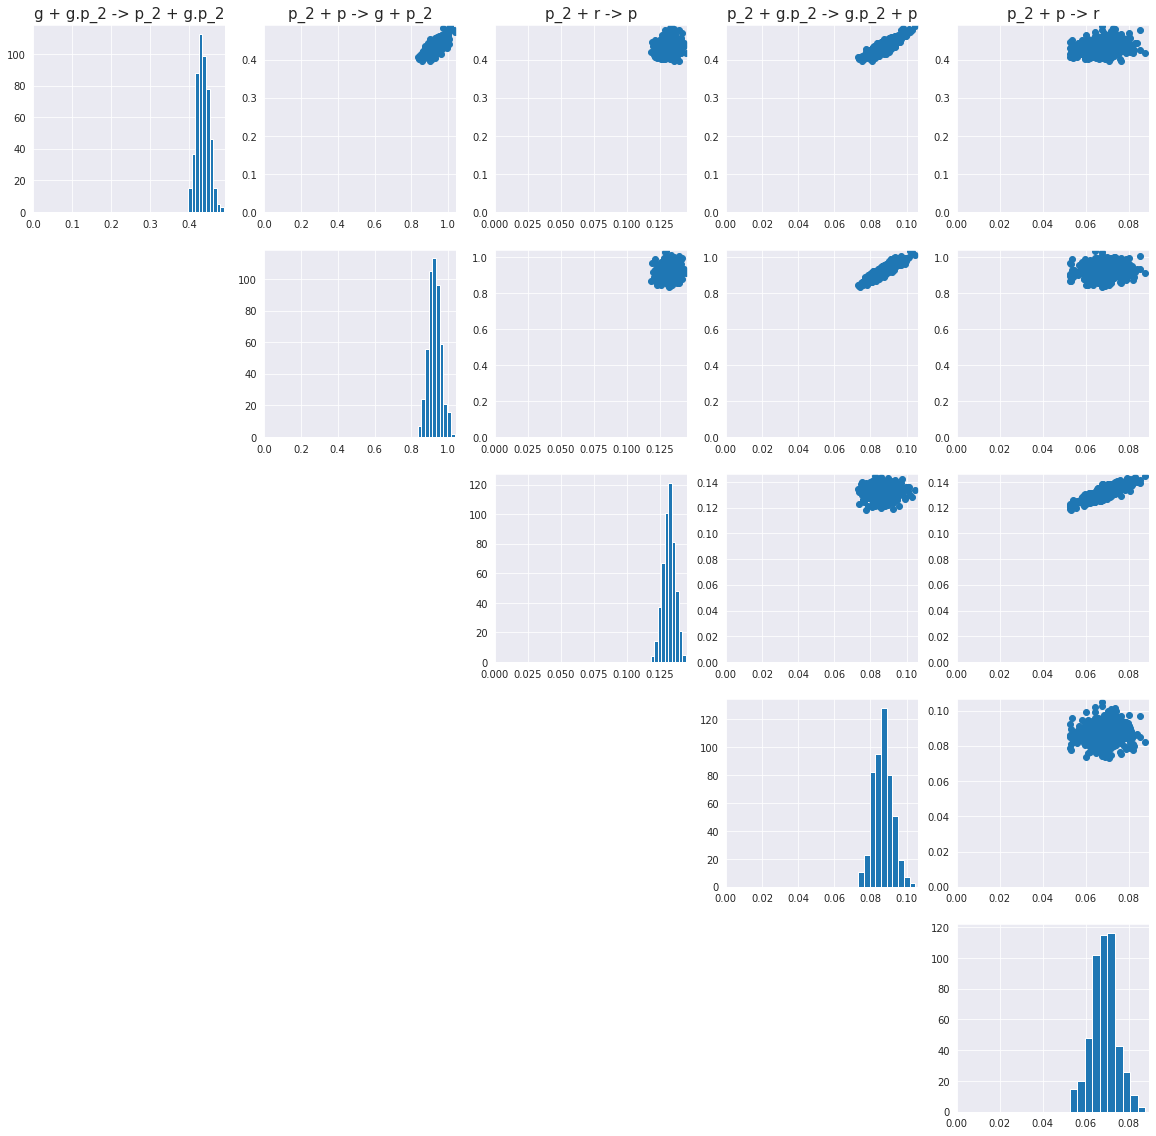

In [39]:
red_samples = samples[501:1000,nonzero_idx[501][4:]]

fig, ax = plt.subplots(red_samples.shape[1], red_samples.shape[1])
for i in range(red_samples.shape[1]):
    ax[0][i].set_title(D[nonzero_idx[501][4:][i]], fontsize = 15)
    for j in range(i, red_samples.shape[1]):
        if i == j:
            ax[i][j].hist(red_samples[:,i])
            ax[i][j].set_xlim([0, None])
        else:
            ax[i][j].scatter(red_samples[:,j], red_samples[:,i])
            ax[i][j].set_xlim([0, None])
            ax[i][j].set_ylim([0, None])
            ax[j][i].axis('off')
fig.set_size_inches(20, 20)
plt.savefig("figures/argn_posterior_2.png", dpi = 400)

In [41]:
np.percentile(red_samples, 50, axis = 0)

array([0.433363 , 0.923428 , 0.131932 , 0.0867781, 0.0685909])

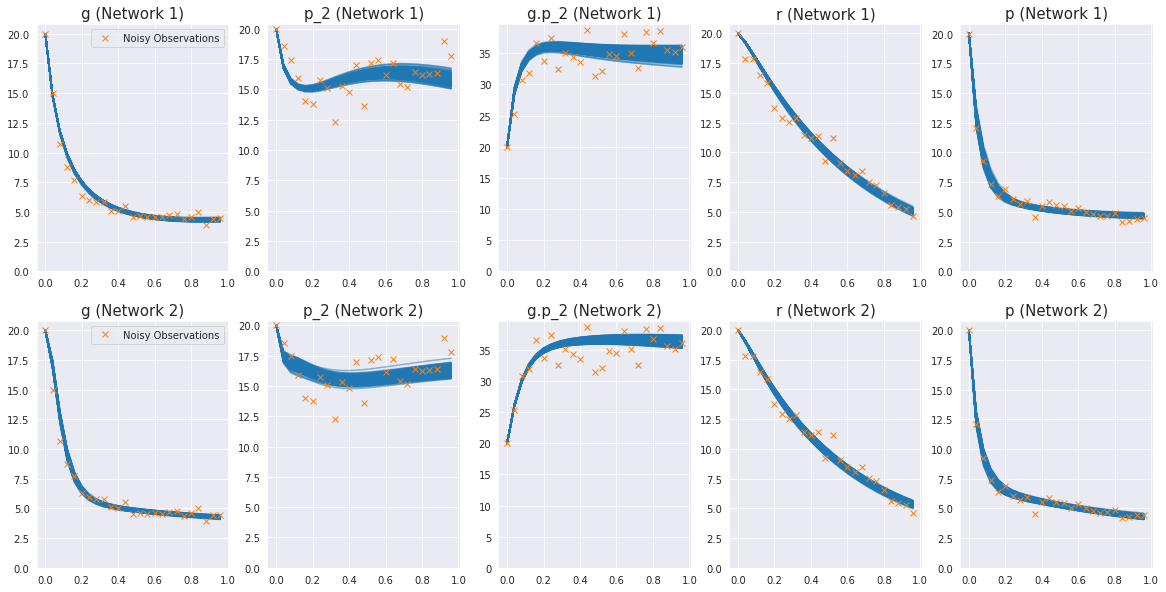

In [14]:
fig, ax = plt.subplots(2,5)
n_nonzero = []
n_nonzero_idx = []
n_nonzero_D = []
samples = fit.stan_variables()['rates']
for j in range(2):
    n_nonzero_chain = []
    n_nonzero_chain_D =  []
    n_nonzero_chain_idx = []
    for i in range(j * 500,j * 500 + 500):
        inferred_rates = samples[i,:]
        inferred_rates[inferred_rates < 1e-3] = 0
        n_nonzero_chain.append(np.sum(inferred_rates != 0))
        n_nonzero_chain_idx.append(np.argwhere(inferred_rates != 0)[:,0])
        n_nonzero_chain_D.append([D[k] for k in np.argwhere(inferred_rates != 0)[:,0]])
        def dZdt_inf(Z, t = 0):

            ap = np.hstack([Z, 1]) * (R == 1)
            ap += (np.hstack([Z, 1]) * (R == 2)) ** 2
            ap_mask = ap + (ap == 0).astype(np.float32)
            extend_Z = np.prod(ap_mask, axis = 1) * inferred_rates
            return (S.T @ extend_Z)[:-1]
        Z_obs_inf = integrate.odeint(dZdt_inf, [20, 20, 20, 20, 20], t)
        for k in range(5):
            ax[j][k].plot(t, Z_obs_inf[:, k], color = 'C0', alpha = 0.5);

    for k in range(5):
        ax[j][k].set_title("%s (Network %d)" % (species_names[k], j + 1), fontsize = 15)
        ax[j][k].plot(t, Z_obs_noisy[:,k], 'x', label = 'Noisy Observations', color = 'C1')
        ax[j][k].set_ylim([0, None])


    ax[j][0].legend()
    n_nonzero.append(n_nonzero_chain)
    n_nonzero_D.append(n_nonzero_chain_D)
    n_nonzero_idx.append(n_nonzero_chain_idx)
fig.set_size_inches(20, 10)
plt.savefig("figures/argn_recovered_trajectories.png", dpi = 400)

In [44]:
p_samples = [
    samples[0:500,nonzero_idx[0][4:]],
    samples[500:1000,nonzero_idx[500][4:]]
]
for k in range(2):
    print("Reaction Network %d" % k)
    median_values = np.percentile(p_samples[k], 50, axis = 0)
    for i in range(len(n_nonzero_D[k][0])):
        if i < 4:
            print("%d (%d): %s" % (i + 1, n_nonzero_idx[k][0][i], n_nonzero_D[k][0][i]))
        else:
            print("%d (%d) %f: %s" % (i + 1, n_nonzero_idx[k][0][i], median_values[i -4 ], n_nonzero_D[k][0][i]))

Reaction Network 0
1 (0): g + p_2 -> g.p_2
2 (1): g.p_2 -> g + p_2
3 (2): g -> g + r
4 (3): r -> r + p
5 (35) 0.043802: g.p_2 + r -> p_2
6 (84) 0.621841: p_2 + p -> p_2 + g.p_2
7 (126) 0.425745: g.p_2 -> 2p
8 (179) 0.149251: g.p_2 + p -> p_2
9 (223) 0.063511: p_2 + g.p_2 -> g.p_2 + p
Reaction Network 1
1 (0): g + p_2 -> g.p_2
2 (1): g.p_2 -> g + p_2
3 (2): g -> g + r
4 (3): r -> r + p
5 (65) 0.433389: g + g.p_2 -> p_2 + g.p_2
6 (80) 0.923401: p_2 + p -> g + p_2
7 (161) 0.131932: p_2 + r -> p
8 (223) 0.086762: p_2 + g.p_2 -> g.p_2 + p
9 (244) 0.068509: p_2 + p -> r
